In [113]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.neighbors import NearestNeighbors

В ДЗ использован датасет https://www.kaggle.com/datasets/uciml/german-credit

In [143]:
df = pd.read_csv('german_credit_data.csv', sep=';')

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [145]:
rows = df.shape[0]
cols = df.shape[1]
numeric_rows = len(df.select_dtypes([np.number]).columns)
print(f'Анализ датасета после работы с признаками: {rows} наблюдений и {cols} признака, из которых {numeric_rows} - числовых, пропуски данных есть.')

Анализ датасета после работы с признаками: 1000 наблюдений и 9 признака, из которых 4 - числовых, пропуски данных есть.


In [146]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [147]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Пропусков в данных досточно много, удалять наблюдения с пропусками нецелесообразно - останется мало наблюдений, будем заполнять пробелы - пропуски в категориальных признаках, создадим для пропусков отдельную категорию:

In [148]:
df['Saving accounts'].fillna(value='unknown',inplace=True)
df['Checking account'].fillna(value='unknown',inplace=True)

In [149]:
df.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

Пропуски в данных устранены

In [150]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


Проверим уникальные признаки по всем категориальным признакам (датасет про Германию, сколько там полов я не уверен )))))):

In [151]:
categorical_columns = df.select_dtypes(exclude=['number','bool_']).columns.to_list()
categorical_dict = {}
for col in categorical_columns:
    categorical_dict[col] = df[col].value_counts().index.tolist()

In [152]:
for col in categorical_columns:
    print(df[col].value_counts())
    print('------------------------------------')

male      690
female    310
Name: Sex, dtype: int64
------------------------------------
own     713
rent    179
free    108
Name: Housing, dtype: int64
------------------------------------
little        603
unknown       183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
------------------------------------
unknown     394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64
------------------------------------
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64
------------------------------------


In [153]:
def feature_plot(feature_name, categorical_feature, categorical_feature_value):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    axes.figure
    for val in categorical_feature_value:
        axes.hist(df[feature_name].loc[df[categorical_feature] == val], 100, alpha=1.0/len(categorical_feature_value), label=val)
    axes.legend(loc='upper right')
    axes.set_title(feature_name)
    plt.tight_layout()
    plt.show()

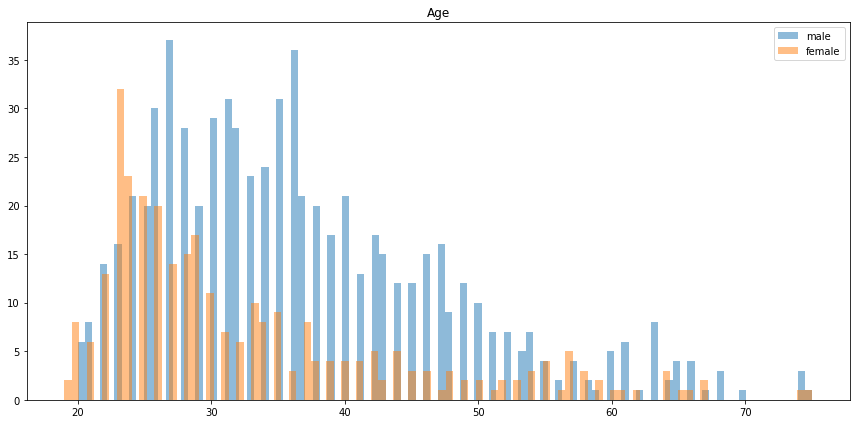

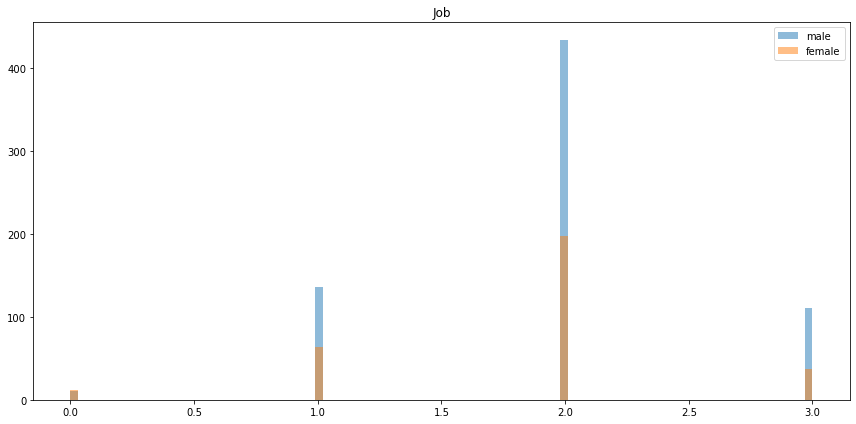

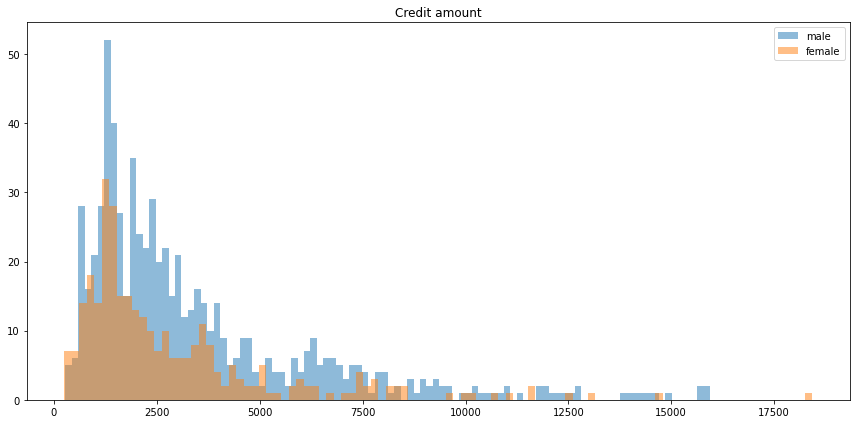

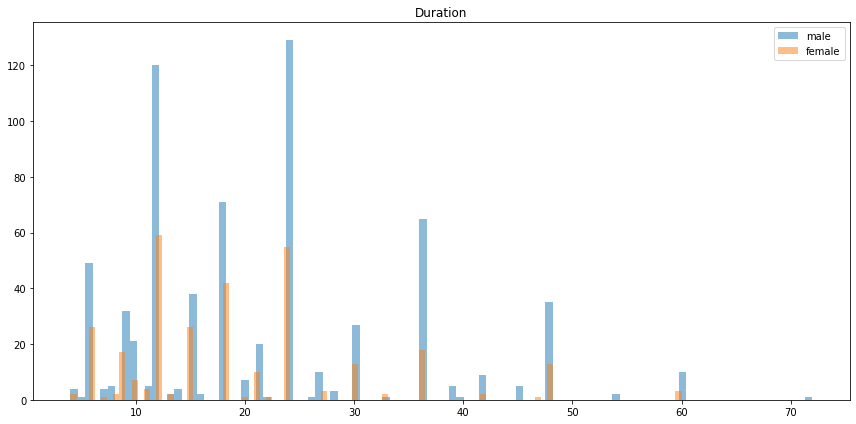

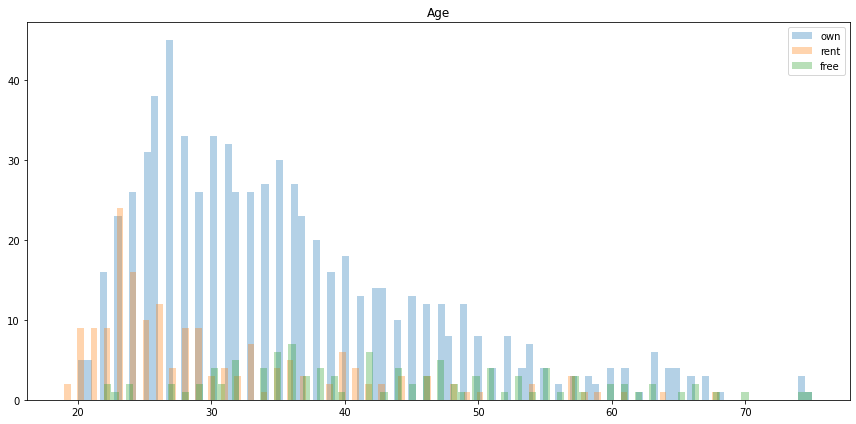

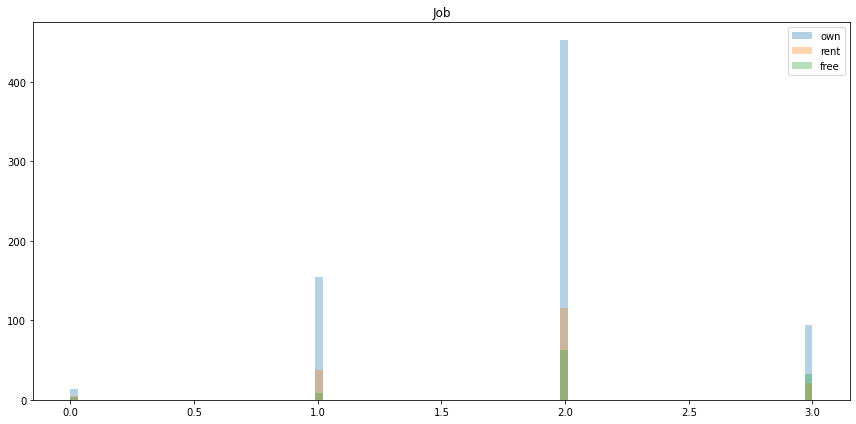

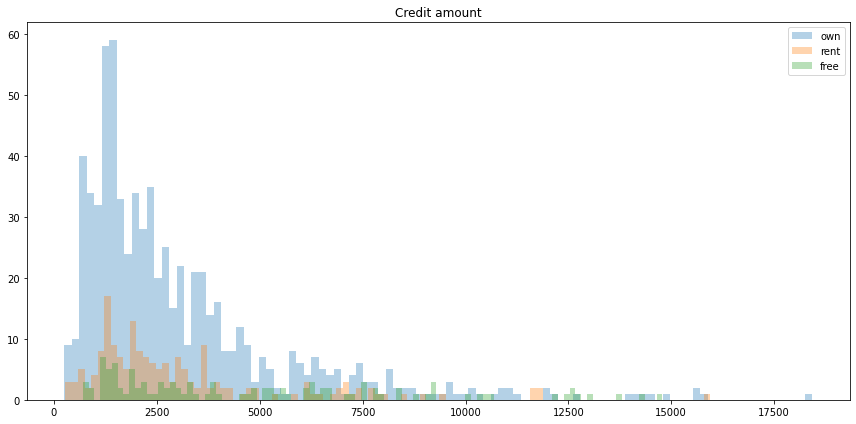

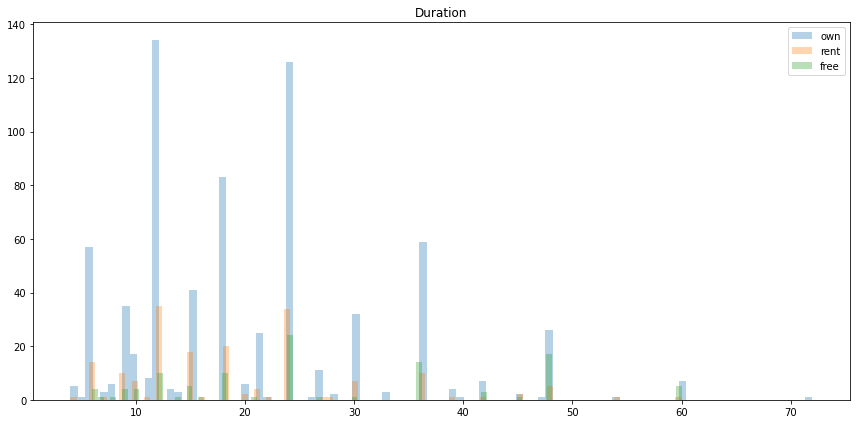

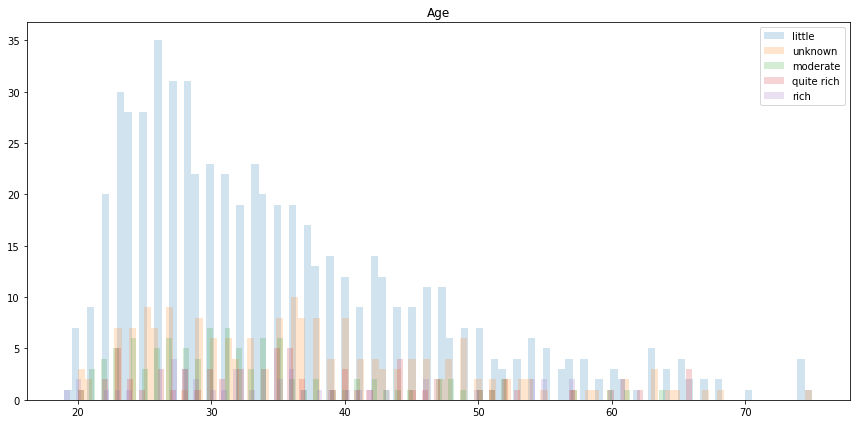

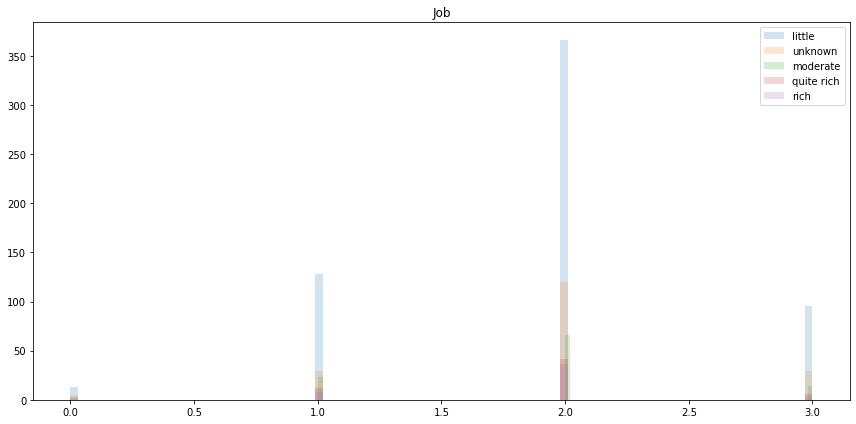

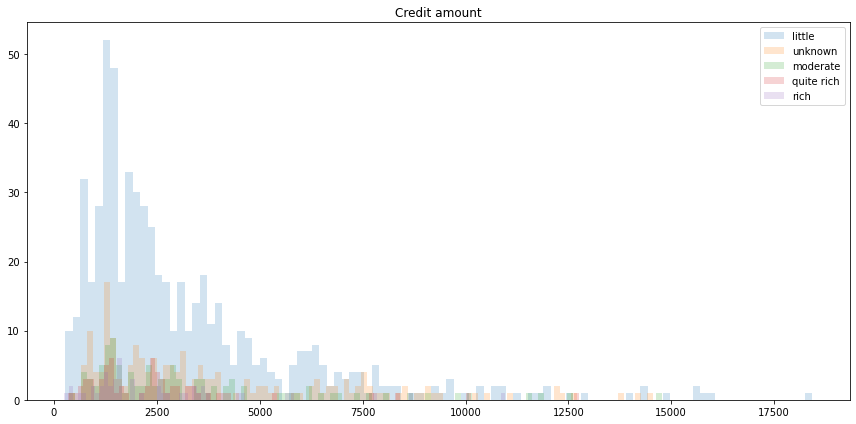

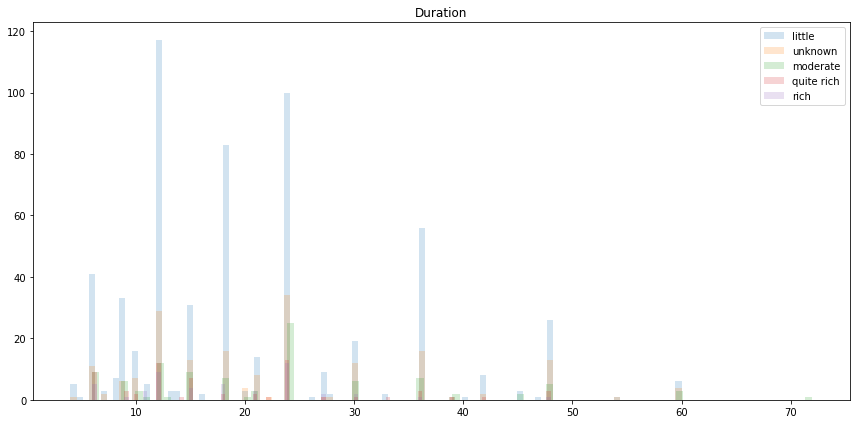

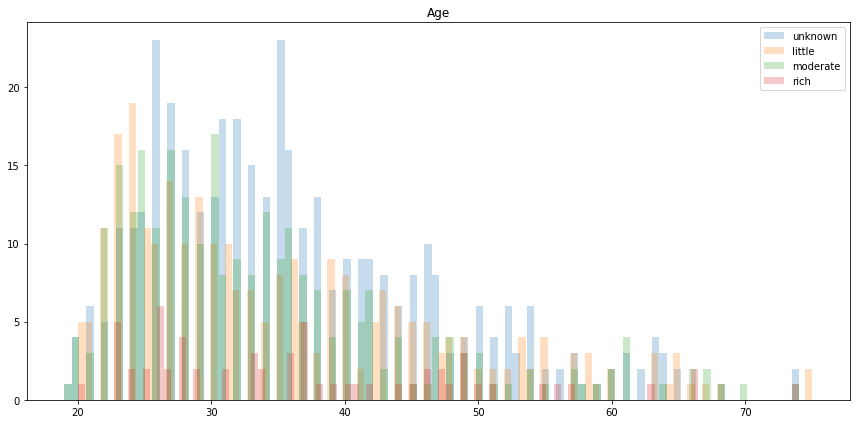

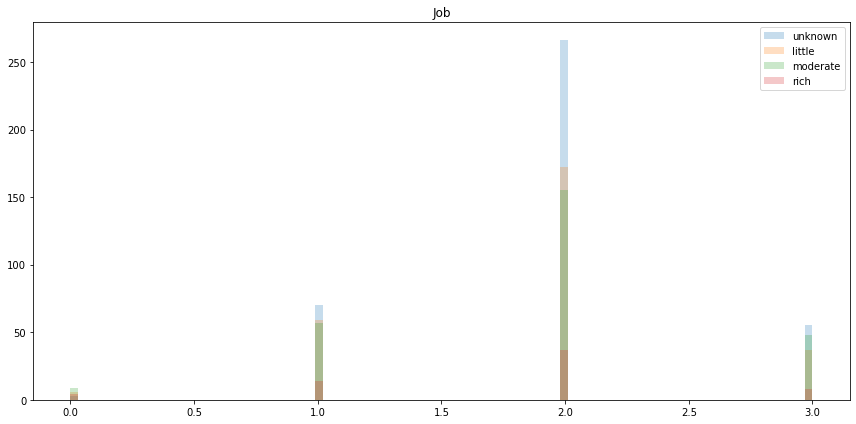

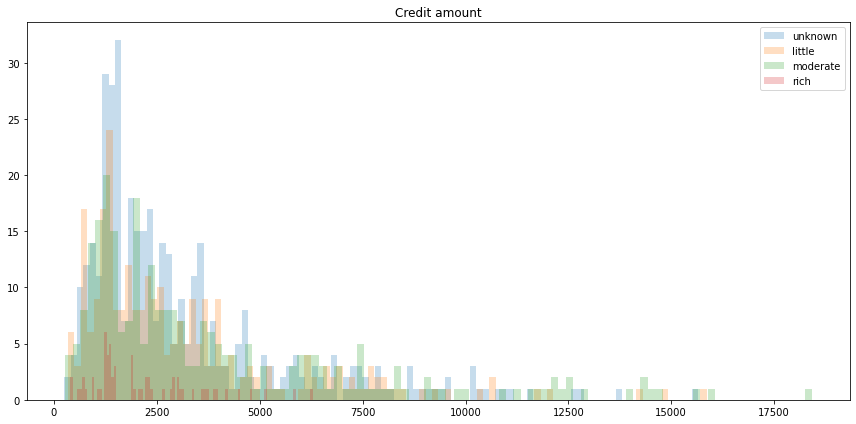

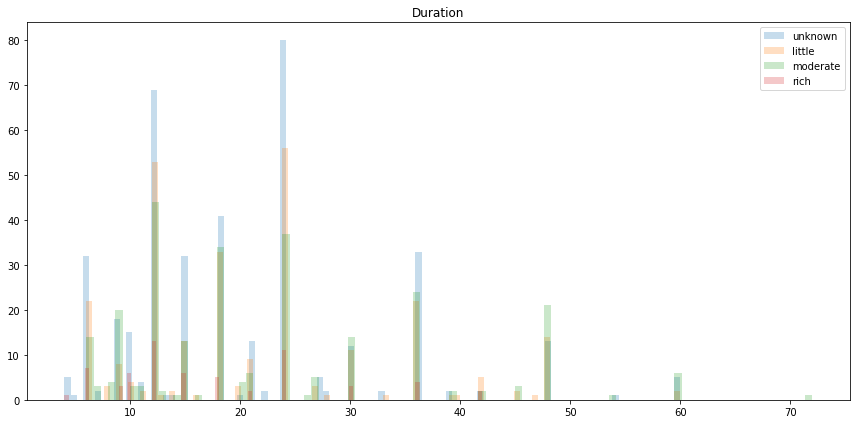

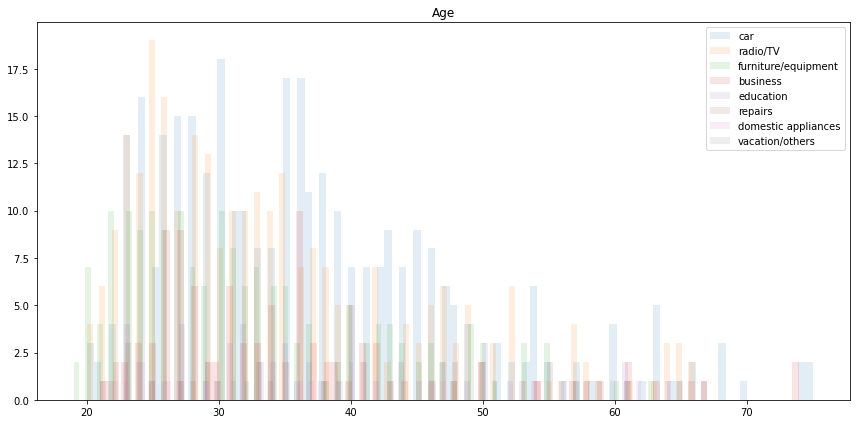

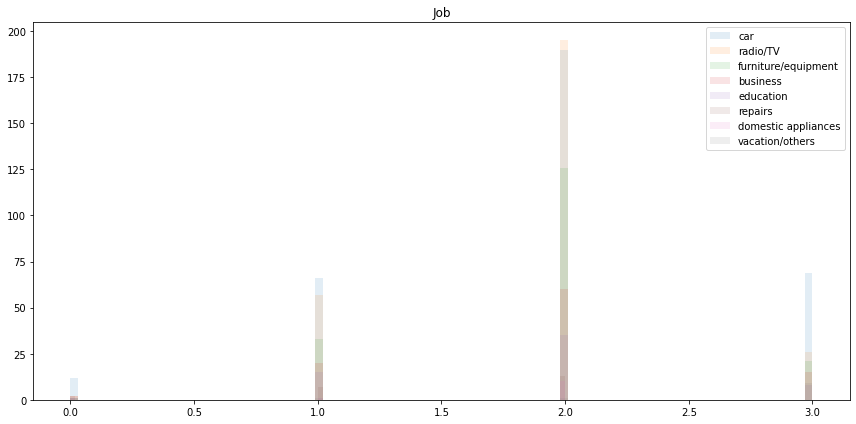

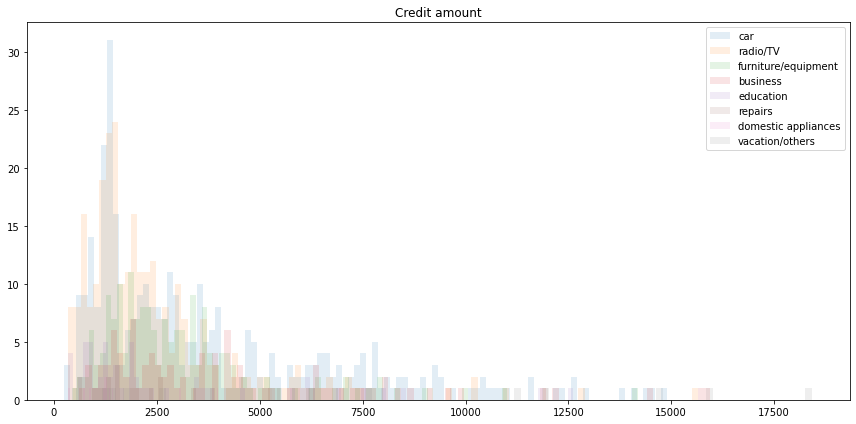

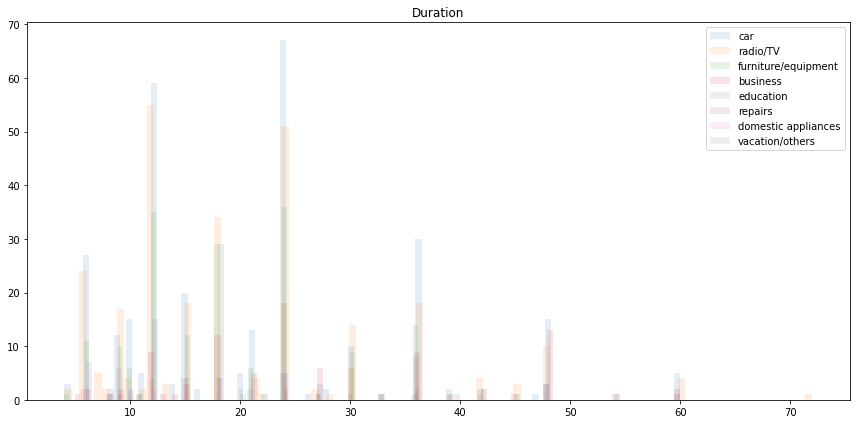

In [154]:
for cat_feat in categorical_dict.items():
    for feature in list(df.select_dtypes([np.number]).columns):
        feature_plot(feature, cat_feat[0], cat_feat[1])

Кодируем признаки согласно условия ДЗ:

В признаках 'Saving accounts' и 'Checking account' есть определенное ранжирование, кодируем их через LabelEncoder:

In [155]:
df['Saving accounts'] = df['Saving accounts'].apply(lambda x: ['unknown', 'little', 'moderate', 'quite rich', 'rich'].index(x))
df['Checking account'] = df['Checking account'].apply(lambda x: ['unknown', 'little', 'moderate', 'rich'].index(x))

Признаки 'Sex', 'Housing' и 'Purpose' не имеют признаком ранжирования, кодируем их OneHotEncoder:

In [156]:
df = pd.get_dummies(df)

Приводим данные к одному масштабу, что необходимо т.к. при расчете расстояний между объектами - все измерения в пространстве должны быть в одних единицах.

In [157]:
scaler = StandardScaler()  #MinMaxScaler
scaler = scaler.fit(df)
df_normalized = scaler.transform(df)

Проводим кластеризацию алгоритмом K-Means:

In [158]:
kmeans = KMeans(n_clusters= 7)
df['kmeans_cluster'] = kmeans.fit_predict(df)

aglomer = AgglomerativeClustering(n_clusters = 7)
df['aglomer_cluster'] = aglomer.fit_predict(df.drop(columns=['kmeans_cluster'], axis=1))  #, 'aglomer_cluster', 'dbscan_cluster'

In [270]:
dbscan = DBSCAN(eps=150, min_samples=1)
df['dbscan_cluster'] = dbscan.fit_predict(df.drop(columns=['kmeans_cluster', 'aglomer_cluster'], axis=1))